# Dump Delight files in mock simulation

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 3rd 2021
- last update : May 13th 2021 : add model on magnitude (works for DC2 data)
- last verification : January 4th 2022

data are in 

        ln -s ../tmp
        ln -s ../tmpsim

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [3]:
FLAG_DC2=False

In [4]:
if FLAG_DC2:
    configfile='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfile='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [5]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfile, verbose=False)

# bands
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
print('bandNames:',bandNames)
numBands, numCoefs = bandCoefAmplitudes.shape

# fluxes and redshift
fluxredshifts = np.loadtxt(params['target_catFile'])
print('target_catFile:',params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
print('training_catFile:',params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn, refBandColumn = readColumnPositions(params, prefix='target_')

# redshift
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
print('templates_directory:',params['templates_directory'])

# filters
dir_filters = params['bands_directory']
print('bands_directory:',params['bands_directory'])
lambdaRef = params['lambdaRef']

#sed
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

bandNames: ['DC2LSST_u', 'DC2LSST_g', 'DC2LSST_r', 'DC2LSST_i', 'DC2LSST_z', 'DC2LSST_y']
target_catFile: ./tmpsim/delight_data/galaxies-fluxredshifts2.txt
training_catFile: ./tmpsim/delight_data/galaxies-fluxredshifts.txt
templates_directory: ../../rail/estimation/data/SED
bands_directory: ../../rail/estimation/data/FILTER


# Check

In [6]:
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(params, prefix="training_")

In [7]:
redshiftColumn

12

In [8]:
bandIndices

array([0, 1, 2, 3, 4, 5])

In [9]:
bandNames

array(['DC2LSST_u', 'DC2LSST_g', 'DC2LSST_r', 'DC2LSST_i', 'DC2LSST_z',
       'DC2LSST_y'], dtype='<U9')

In [10]:
bandColumns

array([ 0,  2,  4,  6,  8, 10])

In [11]:
bandVarColumns

array([ 1,  3,  5,  7,  9, 11])

In [12]:
refBandColumn

6

# Model

In [13]:
f_mod.shape

(300, 8, 6)

## Plot distribution in magnitudes in the model

Text(0.5, 1.01, 'Magnitude distribution for different templates')

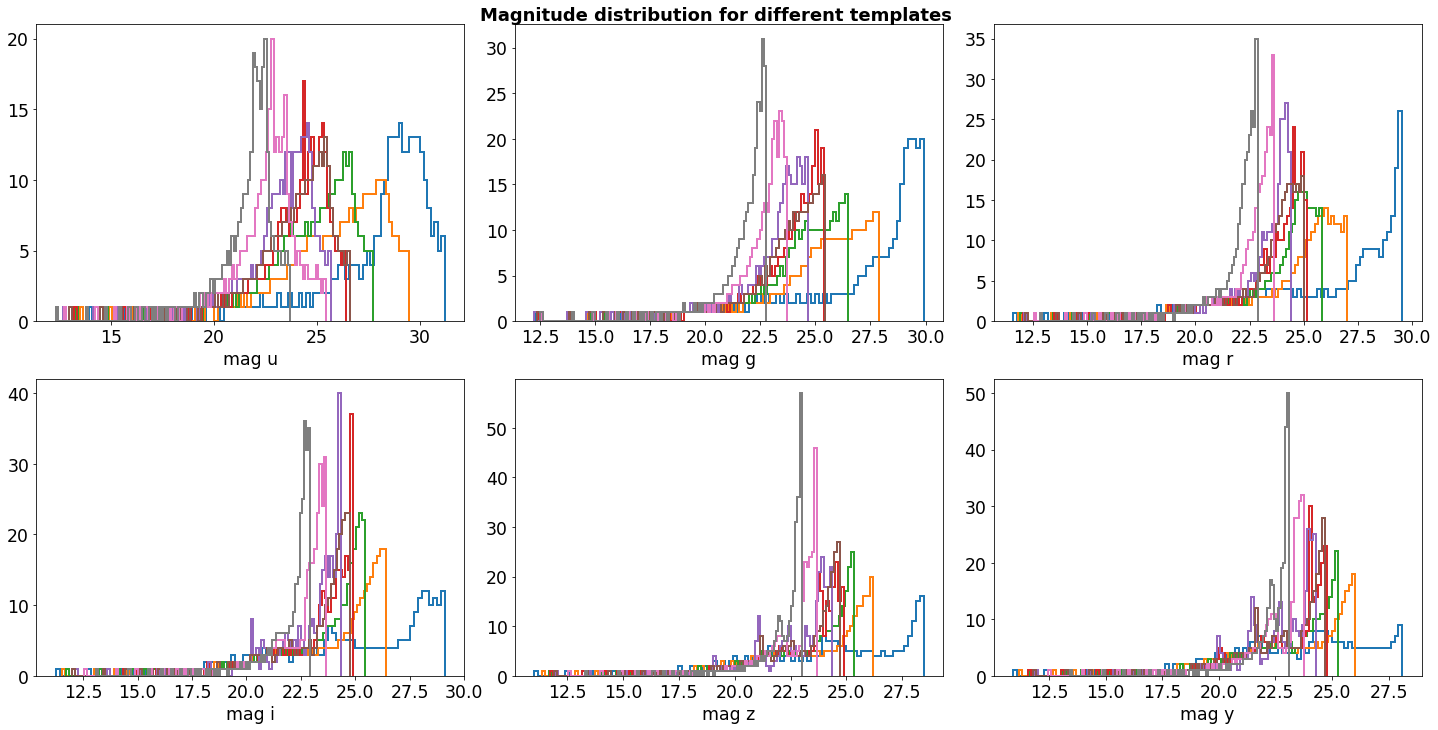

In [14]:
fig=plt.figure(figsize=(20,10))

ax=fig.add_subplot(231)
idb=0
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag u")

ax=fig.add_subplot(232)
idb=1
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag g")

ax=fig.add_subplot(233)
idb=2
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag r")

ax=fig.add_subplot(234)
idb=3
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag i")

ax=fig.add_subplot(235)
idb=4
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag z")

ax=fig.add_subplot(236)
idb=5
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),bins=100,histtype='step',lw=2);
ax.set_xlabel("mag y")

plt.tight_layout()

plt.suptitle("Magnitude distribution for different templates",fontsize=18,fontweight='bold',y=1.01)

Text(0.5, 1.0, 'Generated magnitude distribution for the model (flat z)')

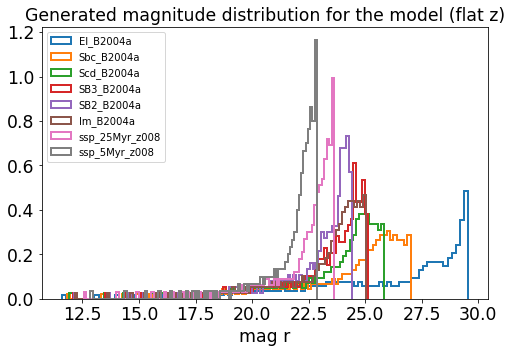

In [15]:
fig=plt.figure(figsize=(8,5))

ax=fig.add_subplot(111)
idb=2
for ids in np.arange(8):
    ax.hist(-2.5*np.log10(f_mod[:,ids,idb]*flux_multiplicative_factor2),density=True,bins=100,label=sed_names[ids],histtype='step',lw=2);
ax.set_xlabel("mag r")
ax.legend(loc="upper left")
ax.set_title("Generated magnitude distribution for the model (flat z)")

# Magnitude model

In [16]:
filt_name= np.array(["u",  "g",  "r",  "i",  "z",  "y"])
mag_max  = np.array([26.1, 27.4, 27.5, 26.8, 26.1, 24.9])
mag_min  = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])

In [17]:
def p_mag(imag_grid,maglim):
    """   
    p_mag(imag_grid,maglim)
    from https://github.com/ixkael/Photoz-tools
    
    input args:
     - imag_grid : magnitude
     - maglim limit of magnitude
     
     return the histogram of magnitudes
     
     THIS IS THE MODEL THAT MUST BE USED
    
    """

    # some parameters for prob(imagnitude)
    alpha = 15.0 
    beta = 2
    off=1

    # prob(imagnitude) distribution
    p_imag = imag_grid**alpha*np.exp(-(imag_grid/(maglim-off))**beta)
    p_imag /= p_imag.sum()
    return p_imag

In [18]:
def det_prob(imag_grid,maglim):
    """
    det_prob(imag_grid,maglim)
    
    Give detection probability of a magnitude
    from https://github.com/ixkael/Photoz-tools
    
    input arg:
    - imag_grid : magnitude grid
    - maglim limit of magnitude
    
    return histogram of magnitude probability
    
    THIS IS THE MODEL THAT MUST BE USED
    
    """
    pp_mag=p_mag(imag_grid,maglim)
    
    detprob = 1*pp_mag 
    ind = (imag_grid >= maglim - 0.4)
    #detprob[ind] *= ( 1 - scipy.special.erf((imag_grid[ind]-maglim+0.4)/0.4) )
    # detection probability looks like a sigmoid
    detprob[ind] *= np.exp( -0.5*((imag_grid[ind]-maglim+0.4)/0.2)**2)
    detprob /= detprob.sum() * (imag_grid[1]-imag_grid[0])
    return detprob

# training

In [19]:
training_file=params['training_catFile']

In [20]:
training_data=np.loadtxt(training_file)

In [21]:
train_redshift=training_data[:,redshiftColumn]

In [22]:
flux_lsst_u=training_data[:,0]*flux_multiplicative_factor
flux_lsst_g=training_data[:,2]*flux_multiplicative_factor
flux_lsst_r=training_data[:,4]*flux_multiplicative_factor
flux_lsst_i=training_data[:,6]*flux_multiplicative_factor
flux_lsst_z=training_data[:,8]*flux_multiplicative_factor
flux_lsst_y=training_data[:,10]*flux_multiplicative_factor

Text(0.5, 1.05, 'Magnitude distribution')

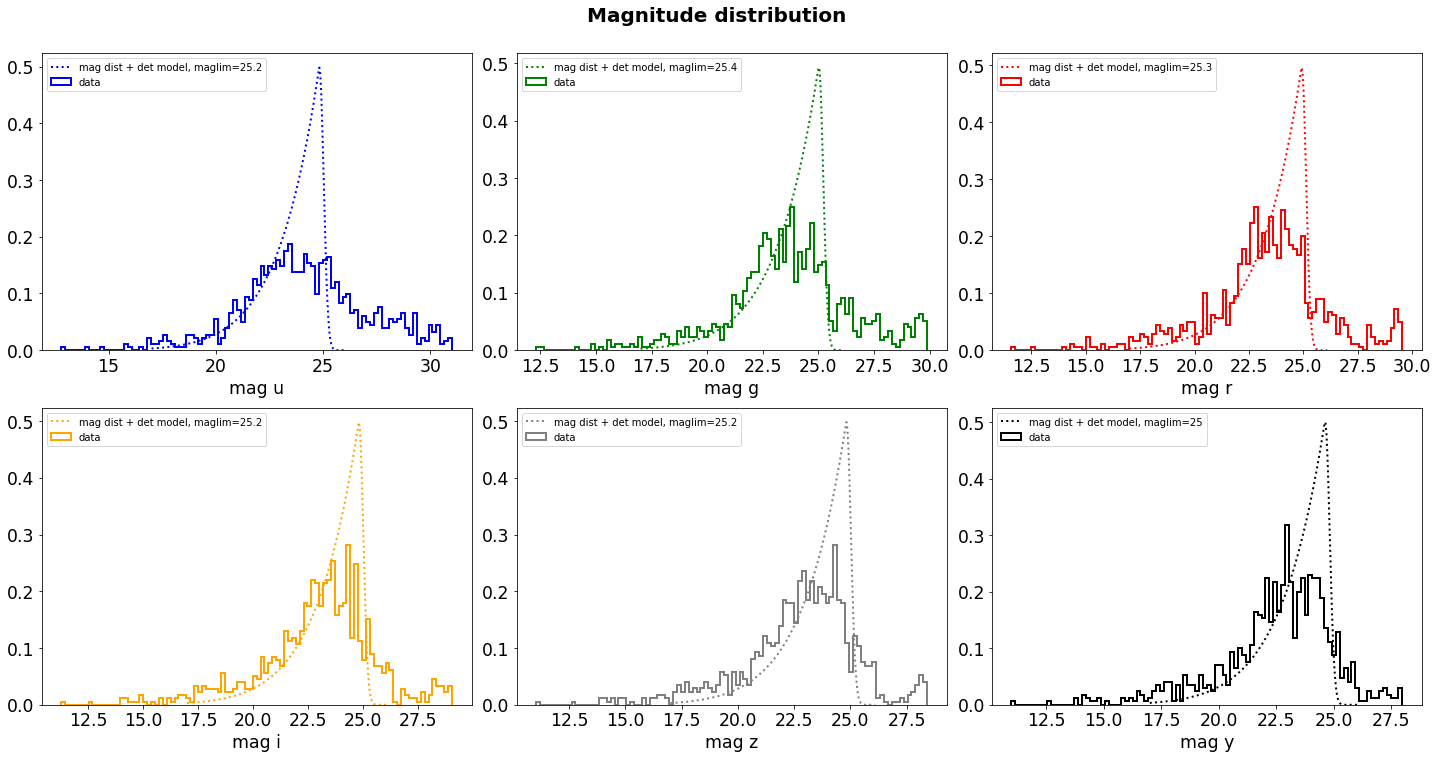

In [23]:
fig=plt.figure(figsize=(20,10))

#--
ax1=fig.add_subplot(231)

ax1.set_xlabel("mag u")
ax1.hist(-2.5*np.log10(flux_lsst_u),bins=100,density=True,color="b",histtype='step',lw=2,label="data");
filt_idx=0
maglim=25.2
mag_grid = np.linspace(17, mag_max[filt_idx], num=200)  # grid for i magnitude : 17 saturation, 28 2 mag above 5sigma thres
ax1.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"b",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax1.legend(loc="upper left")

#---
ax2=fig.add_subplot(232)
ax2.set_xlabel("mag g")
ax2.hist(-2.5*np.log10(flux_lsst_g),bins=100,density=True,color="g",histtype='step',lw=2,label="data");
filt_idx=1
maglim=25.4
ax2.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"g",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax2.legend(loc="upper left")

#----
ax3=fig.add_subplot(233)
ax3.set_xlabel("mag r")
ax3.hist(-2.5*np.log10(flux_lsst_r),bins=100,density=True,color="r",histtype='step',lw=2,label="data");
filt_idx=2
maglim=25.3
ax3.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"r",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax3.legend(loc="upper left")

#---
ax4=fig.add_subplot(234)
ax4.set_xlabel("mag i")
ax4.hist(-2.5*np.log10(flux_lsst_i),bins=100,density=True,color="orange",histtype='step',lw=2,label="data");
filt_idx=3
maglim=25.2
ax4.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"orange",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax4.legend(loc="upper left")

#---
ax5=fig.add_subplot(235)
ax5.set_xlabel("mag z")
ax5.hist(-2.5*np.log10(flux_lsst_z),bins=100,density=True,color="grey",histtype='step',lw=2,label="data");
filt_idx=4
maglim=25.2
ax5.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"grey",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax5.legend(loc="upper left")

#---
ax6=fig.add_subplot(236)
ax6.set_xlabel("mag y")
ax6.hist(-2.5*np.log10(flux_lsst_y),bins=100,density=True,color="k",histtype='step',lw=2,label="data");
filt_idx=5
maglim=25
ax6.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"k",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax6.legend(loc="upper left")

#---
plt.tight_layout()
plt.suptitle("Magnitude distribution",fontsize=20,fontweight='bold',y=1.05)

Text(0.5, 1.0, 'Magnitude distribution in mock data')

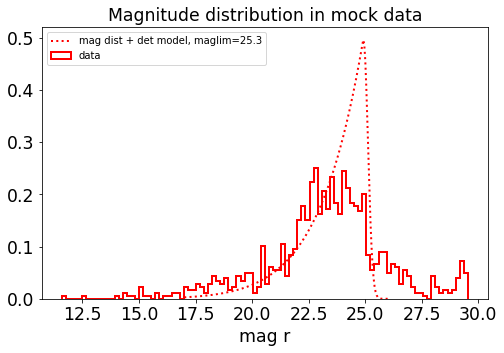

In [24]:
#----
fig=plt.figure(figsize=(8,5))

ax=fig.add_subplot(111)

ax.set_xlabel("mag r")
ax.hist(-2.5*np.log10(flux_lsst_r),bins=100,density=True,color="r",histtype='step',lw=2,label="data");
filt_idx=2
maglim=25.3
ax.plot(mag_grid,det_prob(mag_grid,maglim=maglim),"r",lw=2,ls=":",label="mag dist + det model, maglim={}".format(maglim))
ax.legend(loc="upper left")
ax.set_title("Magnitude distribution in mock data")

In [25]:
delta_m=-2.5*np.log10(flux_lsst_r.min())+2.5*np.log10(flux_lsst_r.max())
delta_m

17.939139452949654

Text(0.5, 1.01, 'Magnitude vs redshift')

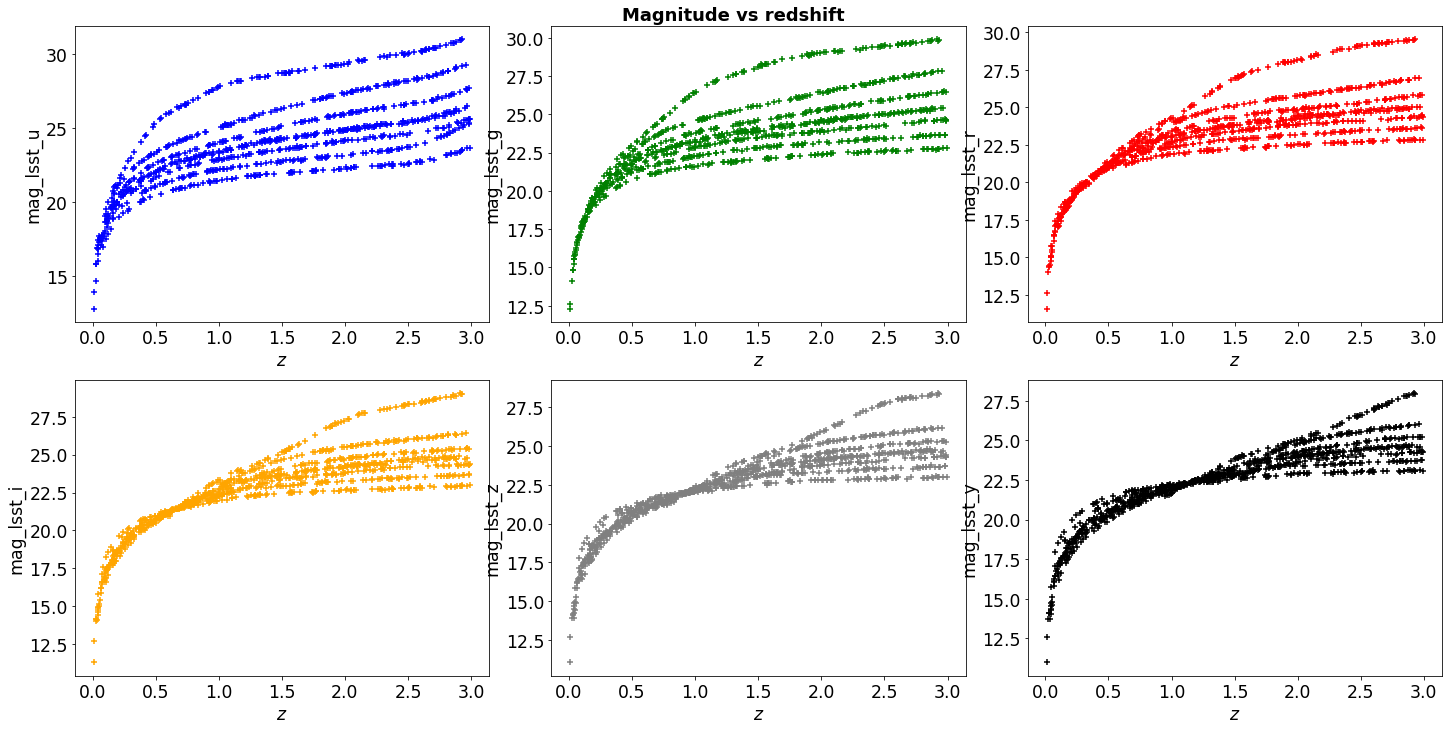

In [26]:
fig=plt.figure(figsize=(20,10))

ax1=fig.add_subplot(231)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_u),marker="+",color='b')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_u")

ax2=fig.add_subplot(232)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_g),marker="+",color='g')
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_g")

ax1=fig.add_subplot(233)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_r),marker="+",color='r')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_r")

ax2=fig.add_subplot(234)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_i),marker="+",color='orange')
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_i")


ax1=fig.add_subplot(235)
ax1.scatter(train_redshift,-2.5*np.log10(flux_lsst_z),marker="+",color='grey')
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_z")

ax2=fig.add_subplot(236)
ax2.scatter(train_redshift,-2.5*np.log10(flux_lsst_y),marker="+",color='k')
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_y")

plt.tight_layout()
plt.suptitle("Magnitude vs redshift",fontsize=18,fontweight='bold',y=1.01)

Text(0.5, 1.01, 'Magnitude vs redshift')

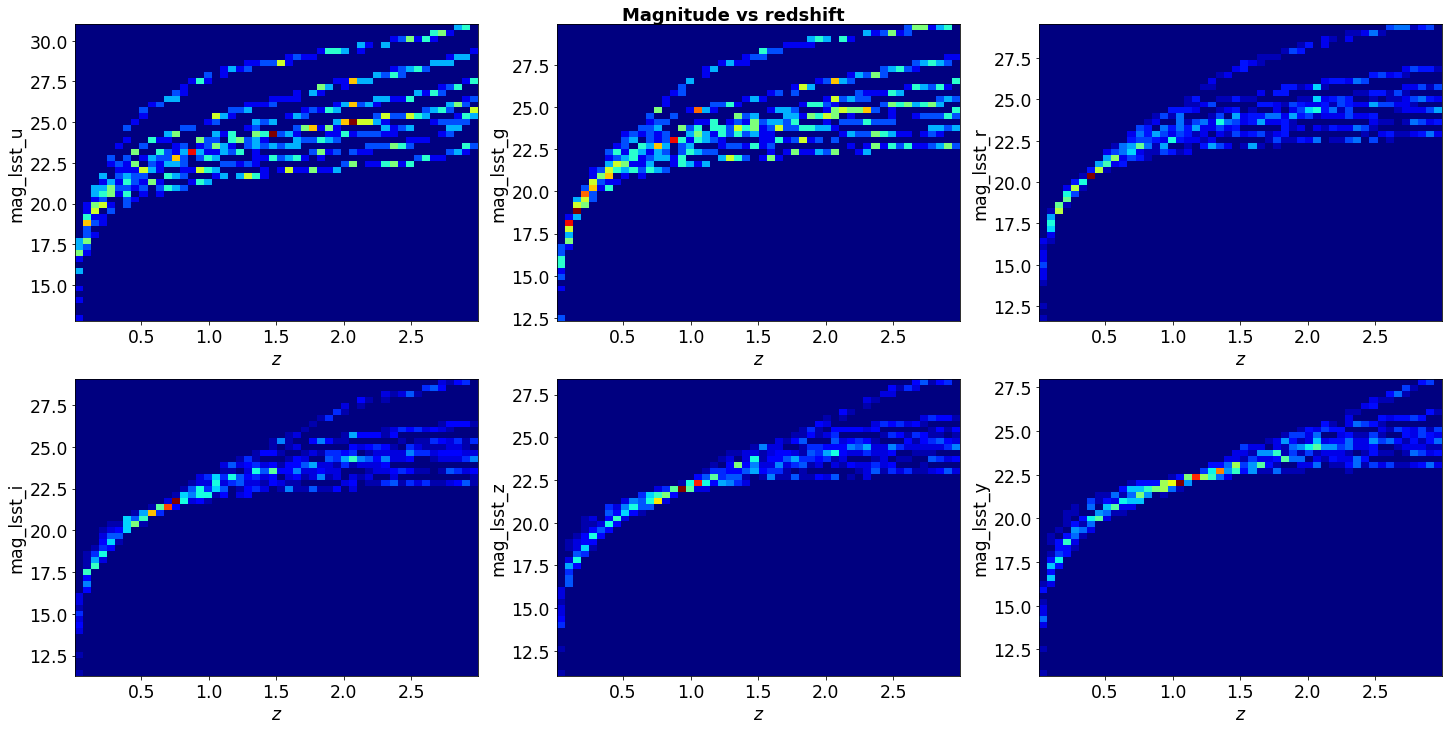

In [27]:
fig=plt.figure(figsize=(20,10))

ax1=fig.add_subplot(231)
ax1.hist2d(train_redshift,-2.5*np.log10(flux_lsst_u),(50,50),cmap="jet")
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_u")

ax2=fig.add_subplot(232)
ax2.hist2d(train_redshift,-2.5*np.log10(flux_lsst_g),(50,50),cmap="jet")
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_g")

ax1=fig.add_subplot(233)
ax1.hist2d(train_redshift,-2.5*np.log10(flux_lsst_r),(50,50),cmap="jet")
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_r")

ax2=fig.add_subplot(234)
ax2.hist2d(train_redshift,-2.5*np.log10(flux_lsst_i),(50,50),cmap="jet")
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_i")


ax1=fig.add_subplot(235)
ax1.hist2d(train_redshift,-2.5*np.log10(flux_lsst_z),(50,50),cmap="jet")
ax1.set_xlabel("$z$")
ax1.set_ylabel("mag_lsst_z")

ax2=fig.add_subplot(236)
ax2.hist2d(train_redshift,-2.5*np.log10(flux_lsst_y),(50,50),cmap="jet")
ax2.set_xlabel("$z$")
ax2.set_ylabel("mag_lsst_y")

plt.tight_layout()
plt.suptitle("Magnitude vs redshift",fontsize=18,fontweight='bold',y=1.01)

Text(0.5, 0, 'z')

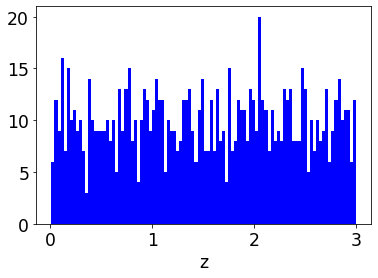

In [28]:
fig=plt.figure(figsize=(6,4))

ax=fig.add_subplot(111)
ax.hist(train_redshift,bins=100,facecolor="b");
ax.set_xlabel("z")